C:\Users\Gbemissola\AppData\Local\Temp\ipykernel_18852\1954739663.py:83: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_trip_updates['actual_arrival_dt'] = pd.to_datetime(df_trip_updates['arrival_time'], errors='coerce')
C:\Users\Gbemissola\AppData\Local\Temp\ipykernel_18852\1954739663.py:84: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_trip_updates['scheduled_arrival_dt'] = pd.to_datetime(df_trip_updates['actual_arrival_dt'].dt.date.astype(str) + ' ' + df_trip_updates['scheduled_arrival'], errors='coerce')


MAE: 66.80391015162284
RMSE: 89.1709330702749


C:\Users\Gbemissola\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


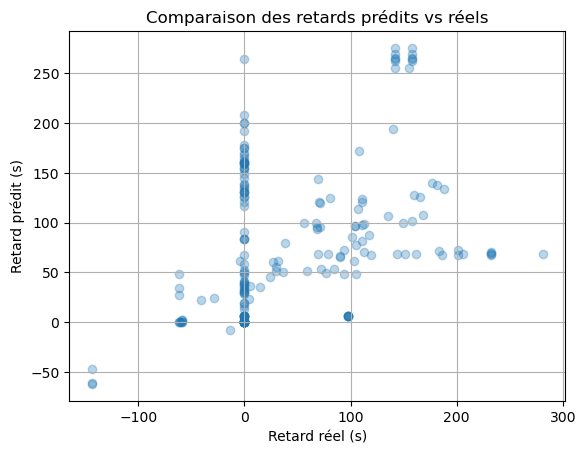

In [1]:
import pandas as pd
import requests
from datetime import datetime
from google.transit import gtfs_realtime_pb2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ========== 1. Chargement des données GTFS ==========
stop_times = pd.read_csv("stop_times.txt")
trips = pd.read_csv("trips.txt")
routes = pd.read_csv("routes.txt")
stops = pd.read_csv("stops.txt")

# ========== 2. Chargement des données GTFS-RT ==========
URL_GTFS_RT = "https://data.grandpoitiers.fr/data-fair/api/v1/datasets/2gwvlq16siyb7d9m3rqt1pb1/metadata-attachments/poitiers.pbf"

def charger_flux_gtfs_rt(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.content
    except Exception as e:
        print(f"Erreur lors du chargement du flux GTFS-RT : {e}")
        return None

def convertir_timestamp(ts):
    try:
        return datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    except:
        return None

data = charger_flux_gtfs_rt(URL_GTFS_RT)
if not data:
    raise SystemExit("Arrêt du programme : impossible de charger les données GTFS-RT.")

feed = gtfs_realtime_pb2.FeedMessage()
feed.ParseFromString(data)

trip_updates = []
for entity in feed.entity:
    if entity.HasField("trip_update"):
        trip_id = entity.trip_update.trip.trip_id
        for stu in entity.trip_update.stop_time_update:
            trip_updates.append({
                "trip_id": trip_id,
                "stop_id": stu.stop_id,
                "arrival_time": convertir_timestamp(stu.arrival.time) if stu.HasField('arrival') else None,
                "arrival_delay": stu.arrival.delay if stu.HasField('arrival') else None
            })

df_trip_updates = pd.DataFrame(trip_updates)

# ========== 3. Préparation des données GTFS statiques ==========
stop_times = stop_times[['trip_id', 'stop_id', 'arrival_time']]
def convert_gtfs_time(t):
    try:
        h, m, s = map(int, t.split(':'))
        h = h % 24
        return f"{h:02d}:{m:02d}:{s:02d}"
    except:
        return None
stop_times['scheduled_arrival'] = stop_times['arrival_time'].apply(convert_gtfs_time)

# Conversion des types
for df in [df_trip_updates, stop_times, trips, routes, stops]:
    for col in df.columns:
        df[col] = df[col].astype(str)

# ========== 4. Jointures GTFS ==========
df_trip_updates = df_trip_updates.merge(trips[["trip_id", "route_id", "trip_headsign"]], on="trip_id", how="left")
df_trip_updates = df_trip_updates.merge(stops[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']], on='stop_id', how='left')
df_trip_updates = df_trip_updates.merge(routes[["route_id", "route_short_name"]], on="route_id", how="left")
df_trip_updates = df_trip_updates.merge(stop_times[['trip_id', 'stop_id', 'scheduled_arrival']], on=['trip_id', 'stop_id'], how='left')

# Ajout date, heure, jour

# Conversion de arrival_time


# Nettoyage des valeurs manquantes et aberrantes
df_trip_updates['actual_arrival_dt'] = pd.to_datetime(df_trip_updates['arrival_time'], errors='coerce')
df_trip_updates['scheduled_arrival_dt'] = pd.to_datetime(df_trip_updates['actual_arrival_dt'].dt.date.astype(str) + ' ' + df_trip_updates['scheduled_arrival'], errors='coerce')

df_trip_updates['heure'] = df_trip_updates['actual_arrival_dt'].dt.hour

df_trip_updates['jour_semaine'] = df_trip_updates['actual_arrival_dt'].dt.day_name()

df_trip_updates['arrival_delay'] = pd.to_numeric(df_trip_updates['arrival_delay'], errors='coerce')

# Nettoyage
clean_df = df_trip_updates.dropna(subset=["arrival_delay", "scheduled_arrival", "stop_lat", "stop_lon", "heure"])
clean_df = clean_df[(clean_df['arrival_delay'] >= -300) & (clean_df['arrival_delay'] <= 1800)]

# ========== 5. Préparation du jeu de données ==========
X = clean_df[["trip_headsign", "stop_name", "route_short_name", "heure", "jour_semaine", "stop_lat", "stop_lon"]]
y = clean_df["arrival_delay"]

X_encoded = pd.get_dummies(X, drop_first=True)

# Validation temporelle (option simple)
train_size = int(0.8 * len(X_encoded))
X_train = X_encoded.iloc[:train_size]
y_train = y.iloc[:train_size]
X_test = X_encoded.iloc[train_size:]
y_test = y.iloc[train_size:]

# ========== 6. Modélisation ==========
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ========== 7. Évaluation ==========
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

# ========== 8. Visualisation ==========
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Retard réel (s)")
plt.ylabel("Retard prédit (s)")
plt.title("Comparaison des retards prédits vs réels")
plt.grid(True)
plt.show()


In [2]:
import joblib

# Entraînement du modèle...
model.fit(X_train, y_train)

# Sauvegarde du modèle
joblib.dump(model, "modele_retard.pkl")

# Sauvegarde des colonnes après encodage
joblib.dump(X_encoded.columns.tolist(), "colonnes_modele.pkl")


['colonnes_modele.pkl']